In [231]:
using Images, FileIO, Plots, TestImages, LinearAlgebra, ImageView
gr()

function sobel_convolve(image, kernel_size = 3, directional_vector::Vector{Float64}=[1.0,0.0])
    
    kernel = gaussian_sobel_kernel(kernel_size, 1, directional_vector)
    convolved_image = zeros((image.size .- (kernel_size, kernel_size)) .+ 1)

    for i in 1:convolved_image.size[1]
        for j in 1:convolved_image.size[2]
            s = sum(image[i:(i+kernel_size - 1), j:(j+kernel_size - 1)] .* kernel)
            convolved_image[i,j] = min(s, 1.0)
        end
    end
    
    # Rescale to 0-1
    min_val = minimum(convolved_image)
    max_val = maximum(convolved_image)
    convolved_image = (convolved_image .- min_val) ./ (max_val - min_val)

    
    return convolved_image
end


function gaussian_convolve(image, kernel_size = 3)
    
    kernel = gaussian_kernel(kernel_size, 1)
    convolved_image = zeros((image.size .- (kernel_size, kernel_size)) .+ 1)

    for i in 1:convolved_image.size[1]
        for j in 1:convolved_image.size[2]
            s = sum(image[i:(i+kernel_size - 1), j:(j+kernel_size - 1)] .* kernel)
            convolved_image[i,j] = min(s, 1.0)
        end
    end

    return convolved_image
end


function gaussian_kernel(size::Int, σ)
    scale = 0.25
    x = range(-scale*σ, scale*σ, size)
    y = range(-scale*σ, scale*σ, size)

    gaussian = [(1/2*π*σ^2)exp(-((xi^2 + yi^2) / (2*σ^2))) for xi in x, yi in y]
    normalized_gaussian = gaussian ./ sum(gaussian)
    return normalized_gaussian
end

function gaussian_sobel_kernel(size::Int, σ, directional_vector::Vector{Float64})
    scale = 0.25
    x = range(-scale*σ, scale*σ, size)

    X_Grid = reshape(x, 1, :) .+ zeros(size, 1)

    G = (1 / (2 * π * σ^2)) .* exp.(-((X_Grid.^2 .+ transpose(X_Grid).^2) ./ (2 * σ^2)))
    δ_gaussian_x = -X_Grid .* G ./ σ^2
    δ_gaussian_y = transpose(δ_gaussian_x)

    # directional derivative 

    ∇ᵤG = directional_vector[1] .* δ_gaussian_x .+ directional_vector[2] .* δ_gaussian_y

    return ∇ᵤG
end



gaussian_sobel_kernel (generic function with 1 method)

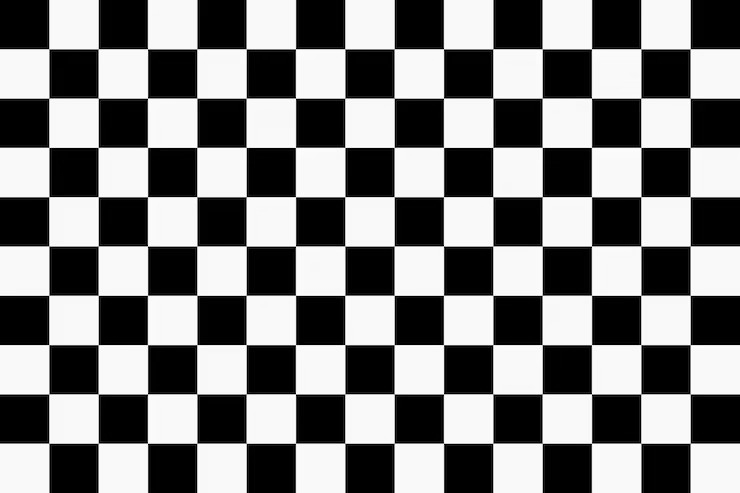

In [232]:
image = Gray.(load("./img.jpg"))


# Förstner–Harris

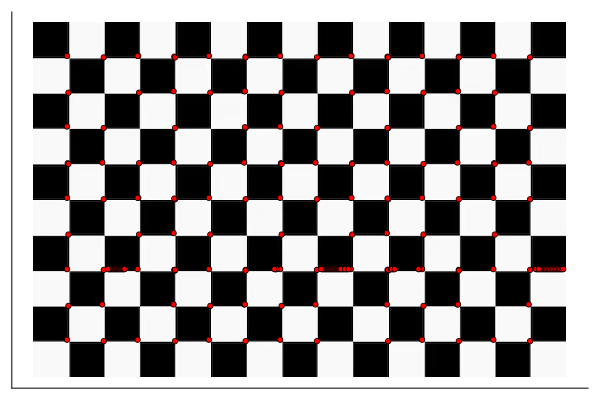

In [233]:
I₁ = (sobel_convolve(image, 3, [1.0, 0.0]))
I₂ = (sobel_convolve(image, 3, [0.0, 1.0]))

# Smooth with gaussian filter in order to obtain ∑ w * A
I₁² = gaussian_convolve(I₁.^2, 3)
I₂² = gaussian_convolve(I₂.^2, 3)
I₁₂ = gaussian_convolve(I₁ .* I₂, 3)

# Extract eigenvalues for each i,j pixel
keypoint = zeros(I₁.size[1], I₁.size[2])
α = 0.06

for i in 1:I₁².size[1]
     for j in 1:I₁².size[2]
          pixel = (i,j)
          A = [I₁²[i, j] I₁₂[i, j];
               I₁₂[i, j] I₂²[i, j]
              ]

          keypoint[i, j] = det(A) - α * tr(A)^2
     end
end

k = 250
flat_keypoint = vec(keypoint)
indices = partialsortperm(flat_keypoint, 1:k; rev=true)

cart_indices = CartesianIndices(keypoint)
coords = [cart_indices[idx] for idx in indices]

x = [c[2] for c in coords] 
y = [c[1] for c in coords]  


plot(image; color=:grays, axis=nothing, legend=false)
scatter!(x, y, color=:red, markersize=3)

# Brown, Szeliski, and Winder (2005)

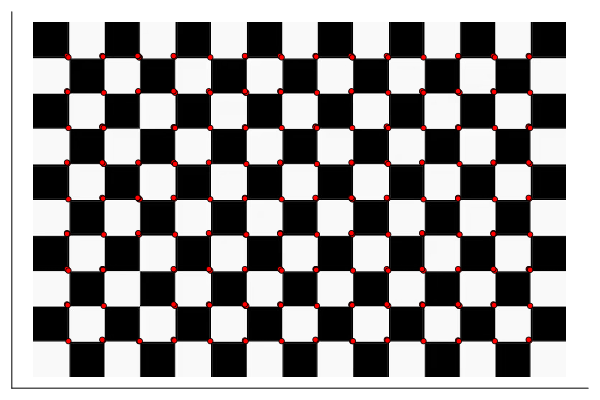

In [221]:
I₁ = (sobel_convolve(image, 3, [1.0, 0.0]))
I₂ = (sobel_convolve(image, 3, [0.0, 1.0]))

# Smooth with gaussian filter in order to obtain ∑ w * A
I₁² = gaussian_convolve(I₁.^2, 3)
I₂² = gaussian_convolve(I₂.^2, 3)
I₁₂ = gaussian_convolve(I₁ .* I₂, 3)

# Extract eigenvalues for each i,j pixel
keypoint = zeros(I₁.size[1], I₁.size[2])
α = 0.06

for i in 1:I₁².size[1]
     for j in 1:I₁².size[2]
          pixel = (i,j)
          A = [
               I₁²[i, j] I₁₂[i, j];
               I₁₂[i, j] I₂²[i, j]
              ]
          keypoint[i, j] = det(A) / tr(A)
     end
end

k = 250
flat_keypoint = vec(keypoint)
indices = partialsortperm(flat_keypoint, 1:k; rev=true)

cart_indices = CartesianIndices(keypoint)
coords = [cart_indices[idx] for idx in indices]

x = [c[2] for c in coords] 
y = [c[1] for c in coords]  


plot(image; color=:grays, axis=nothing, legend=false)
scatter!(x, y, color=:red, markersize=3)